In [1]:
%matplotlib inline
%pdb on

from pprint import pprint
import itertools
import numpy

import metrics
import montecarlo
import dms
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import make_rebalancer, PrimeHarvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

Automatic pdb calling has been turned ON


In [2]:
survival_function = mortality.make_mortality(mortality.ANNUITY_2000)

In [3]:
def mer(cashflows, use_semi=False):
    avg = metrics.average(cashflows)
    if use_semi:
        penalty = metrics.semideviation(pandas.Series([float(x) for x in cashflows]), goal=40000)
    else:
        penalty = numpy.std([float(x) for x in cashflows])
    return avg - (1 * penalty)

In [4]:
def run_one_new(dataset, strategy, debug_cashflows=False):
    p = Portfolio(600000, 400000)
    h = make_rebalancer(.6)(p).harvest()
    h.send(None)
    w = strategy(p, h).withdrawals()
    
    def add_debug_log(annual):
        if debug_cashflows:
            debug.append({
                'Returns' : annual.returns,
                'Withdraw' : annual.withdraw_r,
                'Portfolio' : annual.portfolio_r,
                'Withdraw Orig' : annual.withdraw_pct_orig,
            })


    cashflows = []
    returns = []
    debug = []

    # Initial withdrawal at start of retirement
    annual = w.send(None)
    add_debug_log(annual)
    
    cashflows.append(annual.withdraw_r)
    
    for i in dataset:
        annual = w.send(i)
        add_debug_log(annual)

        returns.append(annual.returns)
        cashflows.append(annual.withdraw_r)

    m_stdev = mer(cashflows)
    m_semi = mer(cashflows, use_semi=True)
    
    return (m_stdev, m_semi, returns, debug)

In [5]:
def new_calc(strategies, runs=1000, dataset=montecarlo.historical[60], debug_cashflows=False):
    mer_stdev_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    mer_semidev_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    returns_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[i for i in range(60)])
    
    for i in range(runs):
        # First generate a lifespan, so we know how many years of returns we need to generate
        lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_function)

        returns = (dataset.random_year() for y in range(lifespan))
        pairs = zip(strategies, itertools.tee(returns, len(strategies)))
        
        if debug_cashflows:
            debug_portfolios = pandas.DataFrame(index=numpy.arange(lifespan), columns=[s.__name__ for s in strategies])
            debug_returns = pandas.DataFrame(index=numpy.arange(lifespan), columns=[s.__name__ for s in strategies])
            debug_withdrawals = pandas.DataFrame(index=numpy.arange(lifespan), columns=[s.__name__ for s in strategies])
            debug_withdraw_orig = pandas.DataFrame(index=numpy.arange(lifespan), columns=[s.__name__ for s in strategies])
      
        for (s, r) in pairs:
            (m_std, m_semidev, returns, debug) = run_one_new(r, s, debug_cashflows=debug_cashflows)
            mer_stdev_df.loc[i][s.__name__] = m_std
            mer_semidev_df.loc[i][s.__name__] = m_semidev
            returns_df.loc[i] = returns + [None for _ in range(60-lifespan)]
                                                   
            if debug_cashflows:
                debug_df = pandas.DataFrame(data=debug)
                debug_portfolios[s.__name__] = debug_df['Portfolio']
                debug_returns[s.__name__] = debug_df['Returns']
                debug_withdrawals[s.__name__] = debug_df['Withdraw']
                debug_withdraw_orig[s.__name__] = debug_df['Withdraw Orig']

    if debug_cashflows:
        writer = pandas.ExcelWriter('MER-debug.xlsx')
        debug_portfolios.to_excel(writer, 'Portfolios')
        debug_returns.to_excel(writer, 'Returns')
        debug_withdrawals.to_excel(writer, 'Withdrawals')
        debug_withdraw_orig.to_excel(writer, 'Withdraw Pct')
        writer.save()
        
    return (mer_stdev_df, mer_semidev_df, returns_df)

In [6]:
def FloorCeiling(p, h):
    return withdrawal.FloorCeiling(p, h, rate=.04)

def SmoothedVPW(p, h):
    return withdrawal.RollingAverageSmoothing(withdrawal.VPW(p, h))

strategies = [
    withdrawal.SensibleWithdrawals,
    FloorCeiling,
    withdrawal.Guyton,
    withdrawal.Clyatt,
    withdrawal.Vanguard,
    withdrawal.TiltCapital,
    withdrawal.IRS_RMD,
    withdrawal.FeelFree,
    #withdrawal.ARVA,
    withdrawal.VPW,
    withdrawal.InvertedWithdrawals,
    withdrawal.SimpleFormula,
    withdrawal.RetrenchmentRule,
    withdrawal.ConstantPercentage,
    withdrawal.ConstantWithdrawals,
    withdrawal.EM,
    withdrawal.ECM,
    SmoothedVPW,
#    withdrawal.Model3,
]
mer_stdev_df, mer_semidev_df, returns_df = new_calc(strategies,
                                                    runs=1000,
                                                    dataset=montecarlo.LowYieldsHighValuations(),
                                                    debug_cashflows=False)

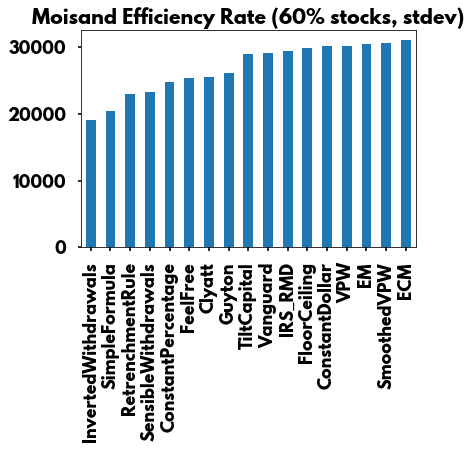

In [7]:
d = [(col, series.mean()) for (col, series) in mer_stdev_df.iteritems()]
series = pandas.Series(dict(d))

series.sort_values(inplace=True)
series.plot(kind='bar', title='Moisand Efficiency Rate (60% stocks, stdev)')

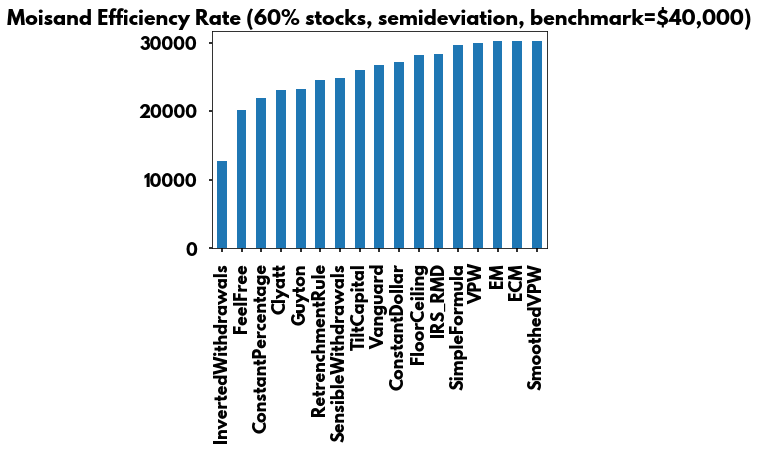

In [8]:
d = [(col, series.mean()) for (col, series) in mer_semidev_df.iteritems()]
series = pandas.Series(dict(d))

series.sort_values(inplace=True)
series.plot(kind='bar', title='Moisand Efficiency Rate (60% stocks, semideviation, benchmark=$40,000)')